In [3]:
import pandas as pd
#!pip install tensorflow==1.14.0
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
import ssl
import math
import matplotlib.pyplot as plt
import operator

from collections import defaultdict
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix, classification_report, f1_score,accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D,BatchNormalization,GlobalMaxPooling1D,MaxPooling1D
from keras.regularizers import l2,l1
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
import xgboost as xgb
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from numpy import loadtxt
from numpy import sort
from numpy import mean
from sklearn.metrics import cohen_kappa_score
#from autoimpute.imputations import MultipleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


from sklearn.impute import SimpleImputer 
from sklearn.metrics import plot_confusion_matrix
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import LeaveOneOut
from collections import Counter
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support,classification_report,confusion_matrix, precision_recall_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### VC

In [4]:
df = pd.read_csv('data_arrhythmia.csv',  sep = ';')
df.head()

,age,sex,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,p_interval,qrs,...,KY,KZ,LA,LB,LC,LD,LE,LF,LG,diagnosis
0,75,0,190,80,91,193,371,174,121,-16,...,0.0,9.0,-0.9,0.0,0,0.9,2.9,23.3,49.4,8
1,56,1,165,64,81,174,401,149,39,25,...,0.0,8.5,0.0,0.0,0,0.2,2.1,20.4,38.8,6
2,54,0,172,95,138,163,386,185,102,96,...,0.0,9.5,-2.4,0.0,0,0.3,3.4,12.3,49.0,10
3,55,0,175,94,100,202,380,179,143,28,...,0.0,12.2,-2.2,0.0,0,0.4,2.6,34.6,61.6,1
4,75,0,190,80,88,181,360,177,103,-16,...,0.0,13.1,-3.6,0.0,0,-0.1,3.9,25.4,62.8,7


In [5]:
# specific to UCI Arrythmia Dataset
class PreProcessing:
    def __init__(self, df):
        self.df = df
        
    def cleaning(self):
        new_df = self.df.copy()
        df_data = new_df.copy()
        # Replace ? by NaN
        df_data = df_data.replace('?', np.NaN)
        # Remove unwanted columns
        # Deleting the attributes having more than 40% missing values.
        thresh = len(df_data) * 0.4
        df_data.dropna(thresh = thresh, axis = 1, inplace = True)
        imp = SimpleImputer(missing_values=np.nan, strategy="median")
        new_df = pd.DataFrame(imp.fit_transform(df_data), columns=df_data.columns)
        self.df = new_df
        return self.df
    
    def getTrainTestSet(self):
        new_df = self.cleaning()
        X = new_df.iloc[:,:-1]
        y = new_df.iloc[:,-1]
        # Implementation for Random forest
        rfc = SelectFromModel(RandomForestClassifier(n_estimators = 20, random_state=0, n_jobs = -1))
        rfc.fit(X, y)

        rfc_comp = X.columns[(rfc.get_support())]
        print("Components from Feature Selection using Random Forest Classifier - ",len(rfc_comp))
        cols = list(X.columns)
        temp = pd.Series(rfc.get_support(),index = cols)
        # reduced Feature dataset based on randomforest classifier
        X = X.loc[:,temp[temp==True].index]
        X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle = True, stratify = y, random_state=43)
        X_train['diagnosis'] = Y_train
        X_test['diagnosis'] = Y_test
        self.df = X_train
        return self.df, X_test

    
    # remving outliers using Isolation Forest
    def OutlierRemoval(self):
        new_df, X_test_df = self.getTrainTestSet()
        new_df.loc[(new_df['diagnosis'] == 1), 'Disease'] = 0 # healthy individual
        new_df.loc[(new_df['diagnosis'] != 1), 'Disease'] = 1 
        new_df_healthy = new_df[new_df['Disease'] == 0]
        new_df_disease = new_df[new_df['Disease'] == 1]
        data = new_df_healthy.drop(columns=['AF', 'Arr']).values
        X , y = data[:, :-1], data[:, -1]
        iso = IsolationForest(random_state=4, contamination=0.2)
        yhat = iso.fit_predict(X)
        # select all rows that are not outliers
        mask = yhat != -1
        afterX, aftery = X[mask, :], y[mask]
        no_outliers = pd.DataFrame(afterX, columns=new_df_healthy.drop(columns=['AF', 'Arr', 'Disease']).columns)
        no_outliers['Disease'] = aftery
        df1 = new_df_healthy.copy()
        df1 = new_df_healthy.set_index('eid')
        df2 = no_outliers.copy()
        df2 = no_outliers.set_index('eid')
        final_healthy_df = pd.merge(df1, df2, how='inner')
        final_healthy_df['eid'] = df2.index
        final_df = pd.concat([final_healthy_df, new_df_disease])
        self.df = final_df
        return self.df, X_test_df
    
    def DataAugmentation(self):
        new_df, X_test_df = self.OutlierRemoval()
        healthy_df = new_df[new_df['Disease'] == 0]
        AF_data = new_df.drop(columns=['Arr'], axis=1) # data with only the AF label
        Arr_data = new_df.drop(columns=['AF'], axis=1) # data with only the Arr label
        arr_smote_x = Arr_data.loc[:,Arr_data.columns != 'Arr']
        arr_smote_y = Arr_data['Arr']

        oversample_arr = SMOTE(sampling_strategy=0.5)
        arr_smote_x, arr_smote_y = oversample_arr.fit_resample(arr_smote_x, arr_smote_y)
        af_smote_x = AF_data.loc[:,AF_data.columns != 'AF']
        af_smote_y = AF_data['AF']

        oversample_af = SMOTE(sampling_strategy=0.5)
        af_smote_x, af_smote_y = oversample_af.fit_resample(af_smote_x, af_smote_y)
        arr_smote_x['Arr'] = arr_smote_y
        af_smote_x['AF'] = af_smote_y
        AF_only = af_smote_x[af_smote_x['AF'] == 1] # data with only positive labels of AF
        Arr_only = arr_smote_x[arr_smote_x['Arr'] ==1] # data with only positive labels of Arr
        with_smote_df = pd.concat([Arr_only,AF_only,healthy_df])
        
        with_smote_df.loc[(with_smote_df['Arr'] == 1) | (with_smote_df['AF'] == 1), 'Disease'] = 1
        with_smote_df.loc[(with_smote_df['Arr'] == 0) & (with_smote_df['AF'] == 0), 'Disease'] = 0
        self.df = with_smote_df
        return self.df, X_test_df
    def finalCleanedDf(self):
        new_df, X_test_df = self.getTrainTestSet()
        new_df.loc[(new_df['diagnosis'] == 1), 'Disease'] = 0 # healthy individual
        new_df.loc[(new_df['diagnosis'] != 1), 'Disease'] = 1 # unhealthy individual
        X_test_df.loc[(X_test_df['diagnosis'] == 1), 'Disease'] = 0 # healthy individual
        X_test_df.loc[(X_test_df['diagnosis'] != 1), 'Disease'] = 1 # unhealthy individual
        self.df = new_df
        return self.df, X_test_df

In [6]:
instance = PreProcessing(df)
train_df, test_df= instance.finalCleanedDf()

Components from Feature Selection using Random Forest Classifier -  105


<ipython-input-5-b2bcbca8776a>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['diagnosis'] = Y_train
<ipython-input-5-b2bcbca8776a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['diagnosis'] = Y_test


In [7]:
train_df.head()

,age,height,weight,qrs_duration,p-r_interval,q-t_interval,t_interval,T,QRST,heart_rate,...,KS,KT,KU,KV,KZ,LD,LE,LG,diagnosis,Disease
5,13.0,169.0,51.0,100.0,167.0,321.0,174.0,66.0,88.0,84.0,...,3.3,20.1,49.1,0.0,12.2,0.9,2.2,31.1,14.0,1.0
114,29.0,172.0,69.0,93.0,129.0,390.0,137.0,17.0,47.0,57.0,...,1.7,19.0,30.2,-0.5,11.9,0.3,1.7,30.6,6.0,1.0
84,63.0,160.0,80.0,83.0,180.0,381.0,145.0,79.0,82.0,50.0,...,2.3,27.4,43.0,-0.7,8.5,0.2,1.5,32.5,6.0,1.0
22,36.0,153.0,75.0,71.0,132.0,364.0,169.0,56.0,60.0,77.0,...,2.0,19.4,37.8,-0.1,8.9,0.5,1.7,34.3,1.0,0.0
296,59.0,160.0,72.0,97.0,149.0,363.0,251.0,-174.0,-18.0,72.0,...,-2.9,30.1,8.7,-0.8,8.9,0.3,-2.2,14.0,2.0,1.0


### Stage1

In [8]:
X_train = train_df.drop(columns=['diagnosis', 'Disease'])
y_train = train_df['diagnosis']


X_test = test_df.drop(columns=['diagnosis','Disease'])
y_test = test_df['diagnosis']

In [9]:
estimators = []

model1 = xgb.XGBClassifier(objective='multi:softmax', subsample=0.75,  
                          n_estimators=100, colsample_bytree = 0.99, learning_rate = 1,
                max_depth = 10,  gamma=5, alpha = 1, seed=123, use_label_encoder=False, eval_metric='error')

estimators.append(('XGBoost', model1))
estimators.append(('bayes', GaussianNB()))
estimators.append(('GradientDescent' , SGDClassifier(loss="modified_huber", penalty="elasticnet", max_iter=500)))
ensemble = VotingClassifier(estimators, voting = 'hard')

In [10]:
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)

In [11]:
train_df['diagnosis'].value_counts()

1.0     196
10.0     40
2.0      35
6.0      20
16.0     18
4.0      12
3.0      12
5.0      10
9.0       7
15.0      4
14.0      3
7.0       2
8.0       2
Name: diagnosis, dtype: int64

In [12]:
y_train.value_counts()

1.0     196
10.0     40
2.0      35
6.0      20
16.0     18
4.0      12
3.0      12
5.0      10
9.0       7
15.0      4
14.0      3
7.0       2
8.0       2
Name: diagnosis, dtype: int64

In [13]:
Counter(y_pred)

Counter({2.0: 15,
         4.0: 3,
         1.0: 48,
         6.0: 3,
         10.0: 14,
         5.0: 2,
         15.0: 1,
         9.0: 2,
         3.0: 3})

In [14]:
y_test.value_counts()

1.0     49
10.0    10
2.0      9
6.0      5
16.0     4
3.0      3
5.0      3
4.0      3
9.0      2
7.0      1
15.0     1
14.0     1
Name: diagnosis, dtype: int64

In [15]:
y_pred

array([ 2.,  4.,  1.,  6.,  6., 10., 10., 10., 10.,  1.,  1.,  1.,  1.,
       10.,  5.,  2.,  1.,  1., 10., 15.,  2.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., 10.,  9.,  1.,  1.,  2.,  2.,  1.,  1.,  4.,  1.,  1.,
       10.,  1., 10.,  6.,  2.,  1.,  1.,  3.,  1.,  2.,  1., 10.,  2.,
       10.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  1.,  2.,  2.,  2.,
        3.,  1.,  1.,  1.,  2.,  1.,  5.,  1.,  2.,  9., 10.,  1.,  1.,
        1.,  1.,  1., 10., 10.,  3.,  1.,  4.,  1.,  1.,  2.,  1.,  1.])

In [16]:
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)

In [17]:
cm

array([[37,  6,  0,  1,  0,  1,  0,  0,  4,  0,  0,  0],
       [ 2,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  0,  0,  0,  2,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0,  0,  8,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0]], dtype=int64)

In [18]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['1','2','3','4', '5','6','7','9','10','14','15','16'], 
                     columns = ['1','2','3','4', '5','6','7','9','10','14','15','16'])

In [19]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, y_pred, average='macro')
print('f1_score: %.3f' % f1_score)
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred, average='macro')
print('Precision: %.3f' % precision)

from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred, average='macro')
print('Recall: %.3f' % recall)

f1_score: 0.498
Precision: 0.512
Recall: 0.506


C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


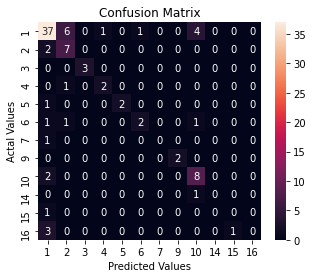

In [20]:
#importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.77      0.76      0.76        49
         2.0       0.47      0.78      0.58         9
         3.0       1.00      1.00      1.00         3
         4.0       0.67      0.67      0.67         3
         5.0       1.00      0.67      0.80         3
         6.0       0.67      0.40      0.50         5
         7.0       0.00      0.00      0.00         1
         9.0       1.00      1.00      1.00         2
        10.0       0.57      0.80      0.67        10
        14.0       0.00      0.00      0.00         1
        15.0       0.00      0.00      0.00         1
        16.0       0.00      0.00      0.00         4

    accuracy                           0.69        91
   macro avg       0.51      0.51      0.50        91
weighted avg       0.67      0.69      0.67        91



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
